In [ ]:
!pip install datasets
!pip install transformers
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import numpy as np
from datasets import load_dataset, Features, Sequence, Value
from sklearn.metrics import classification_report, accuracy_score
from scipy.special import expit
from transformers import BartTokenizer, BartForSequenceClassification, TrainingArguments, Trainer

# Load dataset
dataset = load_dataset("go_emotions")

model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForSequenceClassification.from_pretrained(
    model_name,
    num_labels=28,
    problem_type="multi_label_classification"
)
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [ ]:
# Tokenize and one-hot encode labels
def preprocess_function(examples):
    tokenized = tokenizer(
        examples["text"], truncation=True, padding="max_length", max_length=50
    )

    # One-hot encode the labels
    num_classes = 28
    one_hot_labels = np.zeros((len(examples["labels"]), num_classes), dtype=np.float32)
    for i, labels in enumerate(examples["labels"]):
        one_hot_labels[i, labels] = 1.0

    tokenized["labels"] = one_hot_labels
    return tokenized

tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
new_features = Features(
    {
        "text": Value("string"),
        "labels": Sequence(Value("float32")),
        "id": Value("string"),
        "input_ids": Sequence(Value("int32")),
        "attention_mask": Sequence(Value("int32")),
    }
)

# Cast the dataset to the new type
tokenized_dataset = tokenized_dataset.cast(new_features)

In [ ]:
# Explore the train and validation loss under different batch sizes, learning rates and epochs
# [64, 1e-5, 3] -> [0.099800	0.100183]
# [64, 2e-5, 3] -> [0.085400	0.088904]
# [64, 5e-5, 3] -> [0.075300	0.083415]

# [16, 1e-5, 3] -> [0.083600	0.085937]
# [16, 5e-5, 3] -> [0.069300	0.082378] best
# [16, 1e-4, 3] -> [0.117800	0.115696]
# [16, 1e-6, 3] -> [0.139200	0.134934]
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    fp16=True,
    report_to="none",
)


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-d2871097542b>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Fine-tune the model
trainer.train()

Step,Training Loss,Validation Loss
100,0.184300,0.150569
200,0.150100,0.149221
300,0.146200,0.143079
400,0.138000,0.129249
500,0.122600,0.114468
600,0.115500,0.107353
700,0.106400,0.104083
800,0.104000,0.102338
900,0.103500,0.098937
1000,0.099600,0.096135


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:388: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:388: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning 

TrainOutput(global_step=8142, training_loss=0.08538062052421036, metrics={'train_runtime': 1272.5133, 'train_samples_per_second': 102.341, 'train_steps_per_second': 6.398, 'total_flos': 3901160138796000.0, 'train_loss': 0.08538062052421036, 'epoch': 3.0})

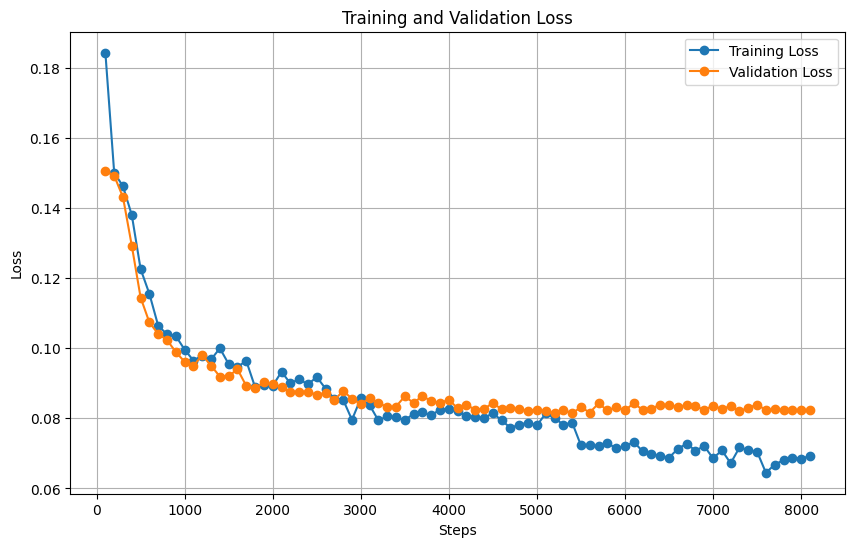

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_losses = []
eval_losses = []
steps = []

for log in log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
        steps.append(log["step"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label="Training Loss", marker="o")
if eval_losses:
    plt.plot(steps[:len(eval_losses)], eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Make predictions
predictions = trainer.predict(tokenized_dataset["test"])

In [ ]:
# Extract logits and labels
logits = predictions.predictions[0]
labels = predictions.label_ids

# Apply sigmoid
probabilities = expit(logits)

# Apply threshold to probabilities
threshold = 0.5
predicted_labels = (probabilities > threshold).astype(int)

# Generate the classification report
print("Test Set Accuracy:", accuracy_score(labels, predicted_labels))
report = classification_report(labels, predicted_labels, output_dict=False, zero_division=0)
print("Detailed Classification Report:\n", report)

Test Set Accuracy: 0.46434494195688225
Detailed Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.73      0.70       504
           1       0.78      0.89      0.83       264
           2       0.55      0.43      0.49       198
           3       0.54      0.19      0.29       320
           4       0.55      0.34      0.42       351
           5       0.44      0.35      0.39       135
           6       0.58      0.38      0.46       153
           7       0.56      0.47      0.51       284
           8       0.69      0.40      0.50        83
           9       0.56      0.21      0.30       151
          10       0.49      0.33      0.40       267
          11       0.66      0.37      0.48       123
          12       0.79      0.41      0.54        37
          13       0.57      0.34      0.43       103
          14       0.72      0.73      0.73        78
          15       0.95      0.90      0.92       352
         